# "*Outer Banks*" Season 3 - *you know*

This notebook visualizes the number of "*you know*" from Season 3 of the TV show ["*Outer Banks*"](https://en.wikipedia.org/wiki/Outer_Banks_(TV_series))

Source code: <https://codeberg.org/penguinsfly/tv-mania/src/branch/main/obx>

## Motivation

Why? cuz *When you know, you know. You know?*

This is because the character Carlos Singh (newly introduced in season 3) says that way too much, almost as if it's a gag from the writers. Sometime he would even start and end a sentence with it. So I just had to count this.

Unfornately, the only data source I could find for transcripts is [Springfield! Springfield!](https://www.springfieldspringfield.co.uk) (see below), which sadly do not contain the names of the characters for each line. 

But Mr. Singh usually says it with a pause, which can be signified by commas. That makes things a bit easier but not perfect, hence the counts & visualizations below are **only for fun**. 

## Obtain data

The data file `outer-banks-2020_scripts.json` was obtained using [`sf2`](https://codeberg.org/penguinsfly/springfield-scraper) that downloaded the scripts from [Springfield! Springfield!](https://www.springfieldspringfield.co.uk).

```bash
sf2 --show "outer-banks-2020" --season 3 --format json
```

## Import modules

In [1]:
import numpy as np 
import pandas as pd
import re

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from matplotlib import rcParams
rcParams['font.family'] = 'Overpass Nerd Font'
rcParams['font.size'] = 18
rcParams['axes.titlesize'] = 25
rcParams['axes.labelsize'] = 18
rcParams['axes.linewidth'] = 1.5
rcParams['lines.linewidth'] = 1.5
rcParams['lines.markersize'] = 20
rcParams['patch.linewidth'] = 1.5
rcParams['xtick.labelsize'] = 18
rcParams['ytick.labelsize'] = 18
rcParams['xtick.major.width'] = 2
rcParams['xtick.minor.width'] = 2
rcParams['ytick.major.width'] = 2
rcParams['ytick.minor.width'] = 2
rcParams['savefig.dpi'] = 300
rcParams['savefig.transparent'] = False
rcParams['savefig.facecolor'] = 'white'
rcParams['savefig.format'] = 'svg'
rcParams['savefig.pad_inches'] = 0.5
rcParams['savefig.bbox'] = 'tight'

## Load and count

In [3]:
def you_know_line(line):
    
    og_line = line.strip()
    line = og_line.lower()
    
    out = dict(
        has_start = bool(re.findall(r'^\s*you\s+know\s*,', line)),
        has_middle = bool(re.findall(r',\s*you\s+know\s*,.?', line)),
        has_end = bool(re.findall(r',\s*you\s+know[\.\?\!]?$', line)),
    )
    
    if sum(list(out.values())) == 0:
        return None
    
    out['line'] = og_line
    return out


def you_know_script(row):
    script = row['script']
    const = {k: row[k] for k in ['episode']}
    
    yks = []
    for lino, line in enumerate(script.split('\n')):
        yk = you_know_line(line)
        if yk is not None:
            yk['line_index'] = lino
            yks.append(yk)
    
    yk = pd.DataFrame(yks).assign(**const)
    return yk

In [4]:
df = pd.read_json('outer-banks-2020_scripts.json')
df = pd.concat(df.apply(you_know_script, axis=1).to_list(), ignore_index=True)\
        .sort_values(['episode','line_index']).reset_index(drop=True)
df

has_start  has_middle  has_end                                       line  \
0        True       False    False             You know, just some castaways.   
1        True       False    False                       You know, the usual.   
2       False       False     True              would cause sparks, you know.   
3       False       False     True      we share certain interests, you know.   
4       False       False     True  people tried to find that gold, you know.   
..        ...         ...      ...                                        ...   
79      False        True    False      And you too can live, you know, John,   
80      False        True    False              and he did it here, you know,   
81      False       False     True          and I'm gonna find you, you know.   
82      False       False     True                 for much longer, you know.   
83      False       False     True               to keep you alive, you know.   

    line_index  episode  
0          325        1  
1          379        1  
2         1005        1  
3         1026        1  
4         1047        1  
..         ...      ...  
79         728       10  
80         743       10  
81        1145       10  
82        1241       10  
83        1268       10  

[84 rows x 6 columns]

In [5]:
df.filter(regex='has.*').sum(axis=0)

has_start     31
has_middle    16
has_end       38
dtype: int64

In [6]:
df.filter(regex='has.*').sum(axis=1).value_counts()

1    83
2     1
dtype: int64

## Clean counts

There were sentences that actually should have been considered one, hence the following attempts to clean and merge some of them

In [7]:
def merge_line(edf):
    merged_lines = dict()

    rows = edf.to_dict('records')
    for r1, r2 in zip(rows[:-1], rows[1:]):
        if (l2:=r2['line_index']) - (l1:=r1['line_index']) > 1:
            continue
        overlap_pos = any([
            r1[k] and r2[k]
            for k in ['has_start','has_middle','has_end']
        ])
        if overlap_pos:
            continue

        assert l1 not in merged_lines and\
            l2 not in merged_lines

        merged_lines[l1] = (l1+l2)/2
        merged_lines[l2] = (l1+l2)/2

    edf['merged_line'] = edf['line_index'].apply(
        lambda x: merged_lines.get(x, x)
    )
    edf['merged'] = edf['line_index'].apply(
        lambda x: x in merged_lines
    )
    
    return edf

In [8]:
df = df.groupby('episode').apply(merge_line)
mdf = df.groupby(['episode', 'merged_line']).agg(list).reset_index()
for k in ['has_start','has_middle','has_end','merged']:
    mdf[k] = mdf[k].apply(any)  

In [9]:
mdf.filter(regex='has.*').sum(axis=0)

has_start     31
has_middle    16
has_end       38
dtype: int64

In [10]:
 mdf.filter(regex='has.*').sum(axis=1).value_counts()

1    77
2     4
dtype: int64

In [11]:
mdf['has_min_twice'] = mdf.filter(regex='has.*').sum(axis=1) > 1
mdf.query('has_min_twice == True')

episode  merged_line  has_start  has_middle  has_end  \
12        2        183.5       True        True    False   
19        2        741.0       True       False     True   
26        3        517.5       True       False     True   
27        3        578.5       True       False     True   

                                                 line  line_index  merged  \
12  [You know, I built, this fortune myself, you k...  [183, 184]    True   
19         [You know, I never doubted you, you know.]       [741]   False   
26  [You know, I can always tell, when people are ...  [517, 518]    True   
27  [You know, 'cause I know where they live., And...  [578, 579]    True   

    has_min_twice  
12           True  
19           True  
26           True  
27           True

In [12]:
mdf.loc[mdf['has_min_twice'], ['has_start','has_middle','has_end']] = False # avoid double counting

In [13]:
mdf.filter(regex='has.*').sum(axis=0)

has_start        27
has_middle       15
has_end          35
has_min_twice     4
dtype: int64

In [14]:
mdf.filter(regex='has.*').sum(axis=1).value_counts()

1    81
dtype: int64

## Final dataframe for visualization

The data frame is cumulative to facilitate stacked bars

In [15]:
total_cnt = mdf.filter(regex='has*|episode')\
    .groupby('episode')\
    .agg(sum).sum(axis=0).to_dict()

total = len(df)

df_viz = mdf.filter(regex='has*|episode')\
    .groupby('episode')\
    .agg(sum)

df_viz.columns = df_viz.columns.map(lambda x: x.replace('has_',''))

df_viz = df_viz.cumsum(axis=1)

In [16]:
rename_dict = {
    'start': 'only start',
    'middle': 'only middle',
    'end': 'only end',
    'min_twice': 'at least twice'
}

df_viz = df_viz.rename(
    columns=rename_dict
).reset_index()

sentence_positions = list(rename_dict.values())
df_viz

episode  only start  only middle  only end  at least twice
0        1           2            2         9               9
1        2           3            4         9              11
2        3           5            6         9              11
3        4           0            2         3               3
4        5           4            4         4               4
5        6           3            5         9               9
6        7           2            3         5               5
7        8           2            7        11              11
8        9           5            6        10              10
9       10           1            3         8               8

In [17]:
total_cnt = {
    rename_dict[k.replace('has_', '')]: v
    for k, v in total_cnt.items()
}
total = len(mdf)

## Visualization

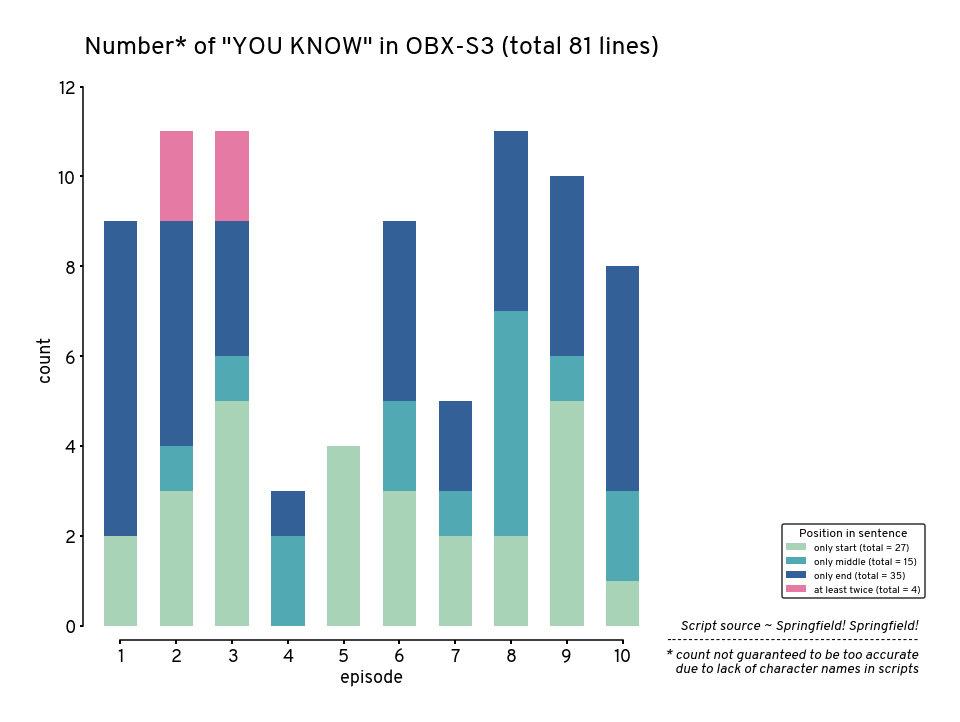

In [18]:
colors = {
    'only start': "#a1dab4", 
    'only middle': "#41b6c4",
    'only end': "#225ea8",
    'at least twice': "#f768a1"
}


plt.figure(figsize=(10,10))
for pos in np.array(sentence_positions)[::-1]:
    sns.barplot(
        data = df_viz,
        x = 'episode', 
        y = pos,
        color=colors[pos],
        label=pos + ' (total = %d)' %(total_cnt[pos]),
        width=0.6
    
    )

# plt.legend(title='position', markerfirst=False)
handles, labels = plt.gca().get_legend_handles_labels()
order = [3,2,1,0]
plt.legend(
    [handles[idx] for idx in order],[labels[idx] for idx in order],
    title='Position in sentence',
    frameon=True,
    loc='lower right',
    bbox_to_anchor=(1.5, 0.05), 
    title_fontsize='large',
    edgecolor='black',
) 
plt.ylabel('count')
plt.title(f'Number* of "YOU KNOW" in OBX-S3 (total {total} lines)', y=1.05)
plt.ylim([-0.1,12])
sns.despine(trim=True, offset=10)

plt.text(
    1.48, 0.02,
    'Script source ~ Springfield! Springfield!\n' +\
    '-'*46 + '\n' +\
    '* count not guaranteed to be too accurate\n' +\
    'due to lack of character names in scripts'
    ,
    transform=plt.gca().transAxes, 
    fontsize=14,
    verticalalignment='top',
    horizontalalignment='right',
    style='italic',
)

plt.savefig('you-know-cnt.svg')
plt.savefig('you-know-cnt.png')
plt.show()